In [34]:
from collections import namedtuple
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split


KerasFeat = namedtuple('Feat', ['name', 'nunique', 'Input'])


def make_sum_layer(name='Sum'):
    layer = tf.keras.layers.Lambda(lambda x: K.sum(x, axis=1))
    layer._name = layer.name if name is None else name
    return layer


def make_square_layer(name='Square'):
    layer = tf.keras.layers.Lambda(lambda x: K.square(x))
    layer._name = layer.name if name is None else name
    return layer


def make_half_layer(name='Half'):
    layer = tf.keras.layers.Lambda(lambda x: x*0.5)
    layer._name = layer.name if name is None else name
    return layer


def plot_keras_model(model, save_to):
    return tf.keras.utils.plot_model(model, save_to, show_shapes=True)


def make_keras_feat(name, nunique):
    return KerasFeat(name,
                     nunique,
                     tf.keras.layers.Input(shape=(1), name=name))


def make_feats(num_names, cat_names, cat_nuniques):
    num_feats = [make_keras_feat(name, 1) for name in num_names]
    cat_feats = [make_keras_feat(name, n + 1) for name, n in zip(cat_names, cat_nuniques)]
    return num_feats, cat_feats


def extract_inputs_from_feats(num_feats, cat_feats):
    num_inputs = [f.Input for f in num_feats]
    cat_inputs = [f.Input for f in cat_feats]
    return num_inputs + cat_inputs


def make_embeding(num_feats=None, cat_feats=None, embsz=None):
    xnum = [tf.keras.layers.Dense(embsz)(f.Input) for f in num_feats]
    xnum = [tf.keras.layers.Reshape((1, embsz))(x) for x in xnum]
    
    xemb = [tf.keras.layers.Embedding(f.nunique, embsz, input_length=1)(f.Input) for f in cat_feats]
    
    return tf.keras.layers.Concatenate(axis=1)(xnum + xemb)


def make_linear_from_embeding(emb):
    x = tf.keras.layers.Flatten()(emb)
    return tf.keras.layers.Dense(1, name='Linear')(x)


def make_interaction_from_embeding(emb):
    sum_emb = make_sum_layer('sum_emb')(emb)
    square_emb = make_square_layer('square_emb')(emb)
    square_of_sum = tf.keras.layers.Multiply(name='square_of_sum')([sum_emb, sum_emb])
    sum_of_square = make_sum_layer('sum_of_square')(square_emb)
    x = tf.keras.layers.Subtract(name='square_of_sum-sum_of_square')([square_of_sum, sum_of_square])
    x = make_sum_layer()(x)
    x = make_half_layer()(x)
    return tf.keras.layers.Reshape((1,))(x)
    
    
def make_fm_model(num_names, cat_names, cat_nuniques, embsz):
    num_feats, cat_feats = make_feats(num_names, cat_names, cat_nuniques)
    
    xemb = make_embeding(num_feats, cat_feats, embsz)
    xlinear = make_linear_from_embeding(xemb)
    xinteraction = make_interaction_from_embeding(xemb)
    
    inputs = extract_inputs_from_feats(num_feats, cat_feats)
    output = tf.keras.layers.Add()([xlinear, xinteraction])
    return tf.keras.models.Model(inputs, output)


Factorization Machine:

$$
\hat{y}(x) = \mathbf{w}_0 + \sum_{i=1}^d \mathbf{w}_i x_i + \sum_{i=1}^d\sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j
$$


Simplification Trick to get Linear time:

$$
\begin{split}\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}\end{split}
$$

In [13]:
names = ['uid','mid','rating','timestamp']
rating = pd.read_csv('./ratings.dat',
                     sep='::',
                     header=None,
                     engine='python',
                     names=names)
names = ['mid','movie_name','movie_genre']
movies = pd.read_csv('./movies.dat',
                     sep='::',
                     header=None,
                     engine='python',
                     names=names)
names = ['uid','user_fea1','user_fea2','user_fea3','user_fea4']
users = pd.read_csv('./users.dat',
                    sep='::',
                    header=None,
                    engine='python',
                    names=names)

rating = (rating.merge(movies, on=['mid'], how='left')
          .merge(users, on=['uid'], how='left'))


num_names = ['user_fea2', 'user_fea3']
cat_names = ['uid', 'mid']
cat_nuniques = [rating[f].max() for f in cat_names]
num_names, cat_names, cat_nuniques


(['user_fea2', 'user_fea3'], ['uid', 'mid'], [6040, 3952])

In [35]:
fm = make_fm_model(num_names, cat_names, cat_nuniques, 3)
fm


In [36]:
fm.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_fea2 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_fea3 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 3)            6           user_fea2[0][0]                  
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 3)            6           user_fea3[0][0]                  
____________________________________________________________________________________________

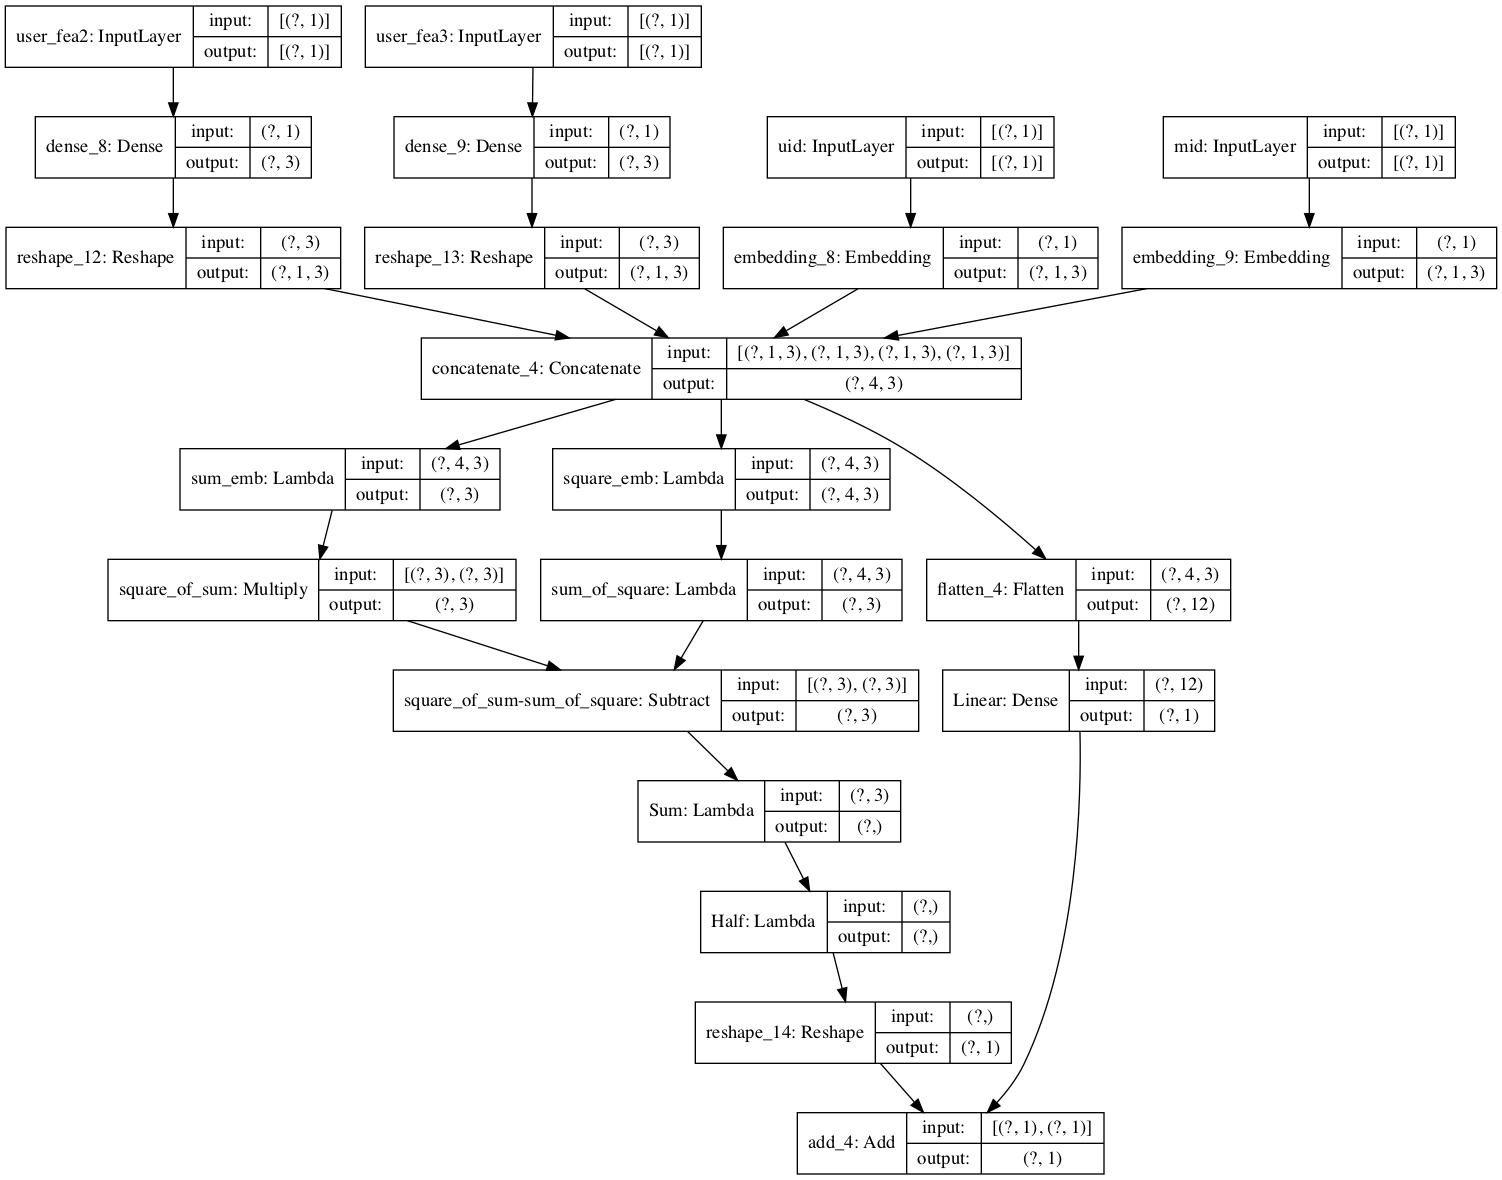

In [37]:
plot_keras_model(fm, 'fm.png')



In [38]:
fm.compile(loss = 'MSE', optimizer='adam')


In [39]:
train, test = train_test_split(rating)
train.shape, test.shape


((750156, 10), (250053, 10))

In [40]:
xtrain = [train[f].values.reshape(-1, 1) for f in num_names + cat_names]
xtest = [test[f].values.reshape(-1, 1) for f in num_names + cat_names]

ytrain = train.rating.values.reshape(-1, 1)
ytest = test.rating.values.reshape(-1, 1)


In [41]:
# Make sure model can fit
fm.fit(xtrain, ytrain, batch_size=64, epochs=3, validation_data=(xtest, ytest))



Train on 750156 samples, validate on 250053 samples
Epoch 1/3
750156/750156 [==============================] - 39s 52us/sample - loss: 2.7604 - val_loss: 1.2051
Epoch 2/3
750156/750156 [==============================] - 33s 44us/sample - loss: 1.2017 - val_loss: 1.1007
Epoch 3/3
750156/750156 [==============================] - 34s 46us/sample - loss: 1.0937 - val_loss: 1.2068


In [42]:
# Make sure model can predict
ytest = fm.predict(xtest, batch_size=64)
ytest.shape


(250053, 1)